# InstructPix2Pix: Learning to Follow Image Editing Instructions

A demo notebook for [InstructPix2Pix](https://www.timothybrooks.com/instruct-pix2pix/) using [diffusers](https://github.com/huggingface/diffusers). InstructPix2Pix is fine-tuned stable diffusion model which allows you to edit images using language instructions.

<img src='https://instruct-pix2pix.timothybrooks.com/teaser.jpg'/>

In [ ]:
!pip install -qqq git+https://github.com/huggingface/diffusers.git gradio transformers accelerate safetensors

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

Download the image for our example

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg

Load the `StableDiffusionInstructPix2PixPipeline` pipeline

In [ ]:
import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision="fp16", safety_checker=None)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
pipe.to(device)
pipe.enable_attention_slicing()

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:429: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_file, framework="pt") as f:
/usr/local/lib/python3.9/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/usr/local/lib/python3.9/dist-packages/torch/storage.py:899: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This sh

Load the image

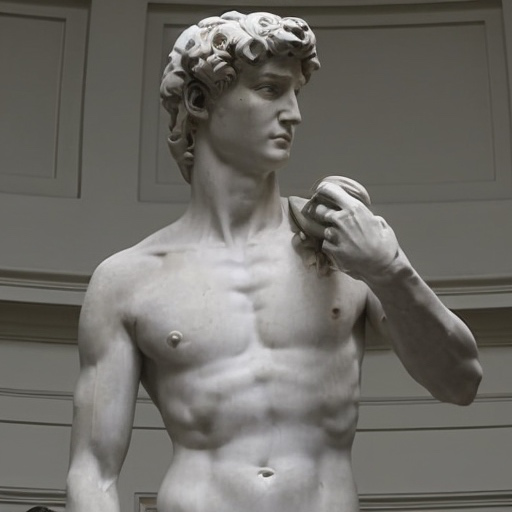

In [ ]:
image = PIL.Image.open("./example.jpg")
image = PIL.ImageOps.exif_transpose(image)
image = image.convert("RGB")
image

  0%|          | 0/30 [00:00<?, ?it/s]

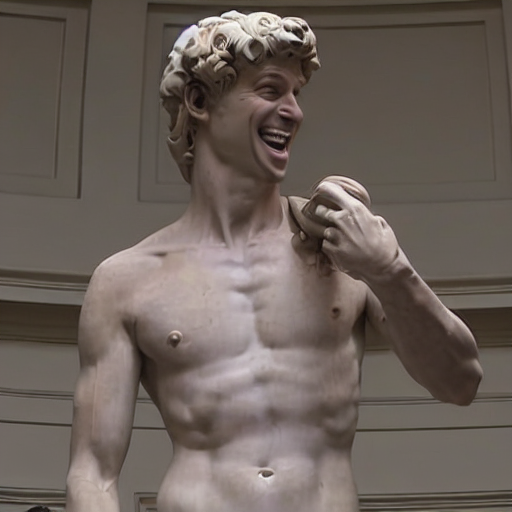

In [ ]:
seed = 68
generator = torch.manual_seed(seed)
target_prompt = "make his face more excited"
test_target = pipe(target_prompt, image=image, num_inference_steps=30, image_guidance_scale=1.05, generator=generator)
test_target.images[0]

In [ ]:
def get_scaled_adjustment(source_tensor: torch.FloatTensor, target_tensor: torch.FloatTensor, scale_factor: float) -> torch.FloatTensor:
    return torch.add(torch.multiply(source_tensor, 1-scale_factor), torch.multiply(target_tensor, scale_factor)).unsqueeze(0)

In [ ]:
import numpy as np
scale_factors = np.arange(0, 1.1, 0.1)
scale_factors

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
text_encoder = pipe.text_encoder.to(device)
tokenizer = pipe.tokenizer

smug_embed = text_encoder(tokenizer(
                "make his face more smug",
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            ).input_ids.to(device))

smug_embed[0].size()

torch.Size([1, 77, 768])

In [ ]:
words = [
  ("amused" , 7197 ,1.3),
  ("excited", 68, 1.05),
  ("victorious", 5252, 1.1),
  ("surprised", 6481, 1.19),
  ("proud", 4990, 1.1),
  ("cocky", 4231, 1.22 ),
  ("confident", 5694, 1.33),
  ("awestruck", 7493, 1.17)
]

In [ ]:
root_word = "smug"
positve_root = "make his face more"

In [ ]:
from pathlib import Path
import os
from google.colab import files

DIR_NAME="./assets"
dirpath = Path(DIR_NAME)
# create parent dir if doesn't exist
dirpath.mkdir(parents=True, exist_ok=True)

In [ ]:
for word in words:
  for scale_factor in scale_factors:
    prompt = f'{positve_root} {word[0]}'
    seed = word[1]
    guidance = word[2]
    print(f'prompt: {prompt}, seed: {seed}, guidance: {guidance}, scale_factor: {scale_factor}')
    generator = torch.manual_seed(seed)

    prompt_embed = text_encoder(tokenizer(
                prompt,
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            ).input_ids.to(device))

    embedding_scaled = get_scaled_adjustment(smug_embed[0][0], prompt_embed[0][0], scale_factor)
    smug = pipe(prompt_embeds=embedding_scaled, image=image, num_inference_steps=30, image_guidance_scale=guidance, generator=generator)

    image_name = f'smug_{int(scale_factor*100)}_{word[0]}.png'
    image_path = os.path.join(dirpath, image_name)
    smug.images[0].save(image_path)

!zip -r /content/assets.zip /content/assets
files.download("/content/assets.zip")

prompt: make his face more amused, seed: 7197, guidance: 1.3, scale_factor: 0.0


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more amused, seed: 7197, guidance: 1.3, scale_factor: 0.1


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more amused, seed: 7197, guidance: 1.3, scale_factor: 0.2


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more amused, seed: 7197, guidance: 1.3, scale_factor: 0.30000000000000004


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more amused, seed: 7197, guidance: 1.3, scale_factor: 0.4


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more amused, seed: 7197, guidance: 1.3, scale_factor: 0.5


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more amused, seed: 7197, guidance: 1.3, scale_factor: 0.6000000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more amused, seed: 7197, guidance: 1.3, scale_factor: 0.7000000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more amused, seed: 7197, guidance: 1.3, scale_factor: 0.8


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more amused, seed: 7197, guidance: 1.3, scale_factor: 0.9


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more amused, seed: 7197, guidance: 1.3, scale_factor: 1.0


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more excited, seed: 68, guidance: 1.05, scale_factor: 0.0


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more excited, seed: 68, guidance: 1.05, scale_factor: 0.1


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more excited, seed: 68, guidance: 1.05, scale_factor: 0.2


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more excited, seed: 68, guidance: 1.05, scale_factor: 0.30000000000000004


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more excited, seed: 68, guidance: 1.05, scale_factor: 0.4


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more excited, seed: 68, guidance: 1.05, scale_factor: 0.5


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more excited, seed: 68, guidance: 1.05, scale_factor: 0.6000000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more excited, seed: 68, guidance: 1.05, scale_factor: 0.7000000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more excited, seed: 68, guidance: 1.05, scale_factor: 0.8


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more excited, seed: 68, guidance: 1.05, scale_factor: 0.9


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more excited, seed: 68, guidance: 1.05, scale_factor: 1.0


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more victorious, seed: 5252, guidance: 1.1, scale_factor: 0.0


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more victorious, seed: 5252, guidance: 1.1, scale_factor: 0.1


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more victorious, seed: 5252, guidance: 1.1, scale_factor: 0.2


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more victorious, seed: 5252, guidance: 1.1, scale_factor: 0.30000000000000004


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more victorious, seed: 5252, guidance: 1.1, scale_factor: 0.4


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more victorious, seed: 5252, guidance: 1.1, scale_factor: 0.5


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more victorious, seed: 5252, guidance: 1.1, scale_factor: 0.6000000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more victorious, seed: 5252, guidance: 1.1, scale_factor: 0.7000000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more victorious, seed: 5252, guidance: 1.1, scale_factor: 0.8


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more victorious, seed: 5252, guidance: 1.1, scale_factor: 0.9


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more victorious, seed: 5252, guidance: 1.1, scale_factor: 1.0


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more surprised, seed: 6481, guidance: 1.19, scale_factor: 0.0


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more surprised, seed: 6481, guidance: 1.19, scale_factor: 0.1


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more surprised, seed: 6481, guidance: 1.19, scale_factor: 0.2


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more surprised, seed: 6481, guidance: 1.19, scale_factor: 0.30000000000000004


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more surprised, seed: 6481, guidance: 1.19, scale_factor: 0.4


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more surprised, seed: 6481, guidance: 1.19, scale_factor: 0.5


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more surprised, seed: 6481, guidance: 1.19, scale_factor: 0.6000000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more surprised, seed: 6481, guidance: 1.19, scale_factor: 0.7000000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more surprised, seed: 6481, guidance: 1.19, scale_factor: 0.8


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more surprised, seed: 6481, guidance: 1.19, scale_factor: 0.9


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more surprised, seed: 6481, guidance: 1.19, scale_factor: 1.0


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more proud, seed: 4990, guidance: 1.1, scale_factor: 0.0


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more proud, seed: 4990, guidance: 1.1, scale_factor: 0.1


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more proud, seed: 4990, guidance: 1.1, scale_factor: 0.2


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more proud, seed: 4990, guidance: 1.1, scale_factor: 0.30000000000000004


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more proud, seed: 4990, guidance: 1.1, scale_factor: 0.4


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more proud, seed: 4990, guidance: 1.1, scale_factor: 0.5


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more proud, seed: 4990, guidance: 1.1, scale_factor: 0.6000000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more proud, seed: 4990, guidance: 1.1, scale_factor: 0.7000000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more proud, seed: 4990, guidance: 1.1, scale_factor: 0.8


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more proud, seed: 4990, guidance: 1.1, scale_factor: 0.9


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more proud, seed: 4990, guidance: 1.1, scale_factor: 1.0


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more cocky, seed: 4231, guidance: 1.22, scale_factor: 0.0


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more cocky, seed: 4231, guidance: 1.22, scale_factor: 0.1


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more cocky, seed: 4231, guidance: 1.22, scale_factor: 0.2


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more cocky, seed: 4231, guidance: 1.22, scale_factor: 0.30000000000000004


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more cocky, seed: 4231, guidance: 1.22, scale_factor: 0.4


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more cocky, seed: 4231, guidance: 1.22, scale_factor: 0.5


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more cocky, seed: 4231, guidance: 1.22, scale_factor: 0.6000000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more cocky, seed: 4231, guidance: 1.22, scale_factor: 0.7000000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more cocky, seed: 4231, guidance: 1.22, scale_factor: 0.8


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more cocky, seed: 4231, guidance: 1.22, scale_factor: 0.9


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more cocky, seed: 4231, guidance: 1.22, scale_factor: 1.0


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more confident, seed: 5694, guidance: 1.33, scale_factor: 0.0


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more confident, seed: 5694, guidance: 1.33, scale_factor: 0.1


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more confident, seed: 5694, guidance: 1.33, scale_factor: 0.2


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more confident, seed: 5694, guidance: 1.33, scale_factor: 0.30000000000000004


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more confident, seed: 5694, guidance: 1.33, scale_factor: 0.4


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more confident, seed: 5694, guidance: 1.33, scale_factor: 0.5


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more confident, seed: 5694, guidance: 1.33, scale_factor: 0.6000000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more confident, seed: 5694, guidance: 1.33, scale_factor: 0.7000000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more confident, seed: 5694, guidance: 1.33, scale_factor: 0.8


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more confident, seed: 5694, guidance: 1.33, scale_factor: 0.9


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more confident, seed: 5694, guidance: 1.33, scale_factor: 1.0


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more awestruck, seed: 7493, guidance: 1.17, scale_factor: 0.0


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more awestruck, seed: 7493, guidance: 1.17, scale_factor: 0.1


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more awestruck, seed: 7493, guidance: 1.17, scale_factor: 0.2


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more awestruck, seed: 7493, guidance: 1.17, scale_factor: 0.30000000000000004


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more awestruck, seed: 7493, guidance: 1.17, scale_factor: 0.4


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more awestruck, seed: 7493, guidance: 1.17, scale_factor: 0.5


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more awestruck, seed: 7493, guidance: 1.17, scale_factor: 0.6000000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more awestruck, seed: 7493, guidance: 1.17, scale_factor: 0.7000000000000001


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more awestruck, seed: 7493, guidance: 1.17, scale_factor: 0.8


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more awestruck, seed: 7493, guidance: 1.17, scale_factor: 0.9


  0%|          | 0/30 [00:00<?, ?it/s]

prompt: make his face more awestruck, seed: 7493, guidance: 1.17, scale_factor: 1.0


  0%|          | 0/30 [00:00<?, ?it/s]

  adding: content/assets/ (stored 0%)
  adding: content/assets/smug_10_surprised.png (deflated 0%)
  adding: content/assets/smug_40_surprised.png (deflated 0%)
  adding: content/assets/smug_50_amused.png (deflated 0%)
  adding: content/assets/smug_100_cocky.png (deflated 0%)
  adding: content/assets/smug_100_awestruck.png (deflated 0%)
  adding: content/assets/smug_60_excited.png (deflated 0%)
  adding: content/assets/smug_30_awestruck.png (deflated 0%)
  adding: content/assets/smug_40_excited.png (deflated 0%)
  adding: content/assets/smug_100_excited.png (deflated 0%)
  adding: content/assets/smug_90_awestruck.png (deflated 0%)
  adding: content/assets/smug_60_confident.png (deflated 0%)
  adding: content/assets/smug_60_proud.png (deflated 0%)
  adding: content/assets/smug_90_proud.png (deflated 0%)
  adding: content/assets/smug_60_surprised.png (deflated 0%)
  adding: content/assets/smug_20_cocky.png (deflated 0%)
  adding: content/assets/smug_0_awestruck.png (deflated 0%)
  adding:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
prompt = 'make his face more excited'
seed = 68
guidance = 1.05
scale_factor=0.9
print(f'prompt: {prompt}, seed: {seed}, guidance: {guidance}, scale_factor: {scale_factor}')
generator = torch.manual_seed(seed)

prompt_embed = text_encoder(tokenizer(
            prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        ).input_ids.to(device))

embedding_scaled = get_scaled_adjustment(smug_embed[0][0], prompt_embed[0][0], scale_factor)
smug = pipe(prompt_embeds=embedding_scaled, image=image, num_inference_steps=30, image_guidance_scale=guidance, generator=generator)

image_name = f'smug_{int(scale_factor*100)}_excited.png'
image_path = os.path.join(dirpath, image_name)
smug.images[0].save(image_path)
files.download(image_path)

prompt: make his face more excited, seed: 68, guidance: 1.05, scale_factor: 0.9


  0%|          | 0/30 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Gradio Demo
from __future__ import annotations

import math
import random

import gradio as gr
import torch
from PIL import Image, ImageOps
from diffusers import StableDiffusionInstructPix2PixPipeline


help_text = """
If you're not getting what you want, there may be a few reasons:
1. Is the image not changing enough? Your Image CFG weight may be too high. This value dictates how similar the output should be to the input. It's possible your edit requires larger changes from the original image, and your Image CFG weight isn't allowing that. Alternatively, your Text CFG weight may be too low. This value dictates how much to listen to the text instruction. The default Image CFG of 1.5 and Text CFG of 7.5 are a good starting point, but aren't necessarily optimal for each edit. Try:
    * Decreasing the Image CFG weight, or
    * Increasing the Text CFG weight, or
2. Conversely, is the image changing too much, such that the details in the original image aren't preserved? Try:
    * Increasing the Image CFG weight, or
    * Decreasing the Text CFG weight
3. Try generating results with different random seeds by setting "Randomize Seed" and running generation multiple times. You can also try setting "Randomize CFG" to sample new Text CFG and Image CFG values each time.
4. Rephrasing the instruction sometimes improves results (e.g., "turn him into a dog" vs. "make him a dog" vs. "as a dog").
5. Increasing the number of steps sometimes improves results.
6. Do faces look weird? The Stable Diffusion autoencoder has a hard time with faces that are small in the image. Try:
    * Cropping the image so the face takes up a larger portion of the frame.
"""


example_instructions = [
    "Make it a picasso painting",
    "as if it were by modigliani",
    "convert to a bronze statue",
    "Turn it into an anime.",
    "have it look like a graphic novel",
    "make him gain weight",
    "what would he look like bald?",
    "Have him smile",
    "Put him in a cocktail party.",
    "move him at the beach.",
    "add dramatic lighting",
    "Convert to black and white",
    "What if it were snowing?",
    "Give him a leather jacket",
    "Turn him into a cyborg!",
    "make him wear a beanie",
]

model_id = "timbrooks/instruct-pix2pix"

def main():
    pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision="fp16", safety_checker=None).to("cuda")
    example_image = Image.open("./example.jpg").convert("RGB")

    def load_example(
        steps: int,
        randomize_seed: bool,
        seed: int,
        randomize_cfg: bool,
        text_cfg_scale: float,
        image_cfg_scale: float,
    ):
        example_instruction = random.choice(example_instructions)
        return [example_image, example_instruction] + generate(
            example_image,
            example_instruction,
            steps,
            randomize_seed,
            seed,
            randomize_cfg,
            text_cfg_scale,
            image_cfg_scale,
        )

    def generate(
        input_image: Image.Image,
        instruction: str,
        steps: int,
        randomize_seed: bool,
        seed: int,
        randomize_cfg: bool,
        text_cfg_scale: float,
        image_cfg_scale: float,
    ):
        seed = random.randint(0, 100000) if randomize_seed else seed
        text_cfg_scale = round(random.uniform(6.0, 9.0), ndigits=2) if randomize_cfg else text_cfg_scale
        image_cfg_scale = round(random.uniform(1.2, 1.8), ndigits=2) if randomize_cfg else image_cfg_scale

        width, height = input_image.size
        factor = 512 / max(width, height)
        factor = math.ceil(min(width, height) * factor / 64) * 64 / min(width, height)
        width = int((width * factor) // 64) * 64
        height = int((height * factor) // 64) * 64
        input_image = ImageOps.fit(input_image, (width, height))

        if instruction == "":
            return [input_image, seed]

        generator = torch.manual_seed(seed)
        edited_image = pipe(
            instruction, image=input_image,
            guidance_scale=text_cfg_scale, image_guidance_scale=image_cfg_scale,
            num_inference_steps=steps, generator=generator,
        ).images[0]
        return [seed, text_cfg_scale, image_cfg_scale, edited_image]

    def reset():
        return [0, "Randomize Seed", 1371, "Fix CFG", 7.5, 1.5, None]

    with gr.Blocks() as demo:
        with gr.Row():
            with gr.Column(scale=1, min_width=100):
                generate_button = gr.Button("Generate")
            with gr.Column(scale=1, min_width=100):
                load_button = gr.Button("Load Example")
            with gr.Column(scale=1, min_width=100):
                reset_button = gr.Button("Reset")
            with gr.Column(scale=3):
                instruction = gr.Textbox(lines=1, label="Edit Instruction", interactive=True)

        with gr.Row():
            input_image = gr.Image(label="Input Image", type="pil", interactive=True)
            edited_image = gr.Image(label=f"Edited Image", type="pil", interactive=False)
            input_image.style(height=512, width=512)
            edited_image.style(height=512, width=512)

        with gr.Row():
            steps = gr.Number(value=10, precision=0, label="Steps", interactive=True)
            randomize_seed = gr.Radio(
                ["Fix Seed", "Randomize Seed"],
                value="Randomize Seed",
                type="index",
                show_label=False,
                interactive=True,
            )
            seed = gr.Number(value=1371, precision=0, label="Seed", interactive=True)
            randomize_cfg = gr.Radio(
                ["Fix CFG", "Randomize CFG"],
                value="Fix CFG",
                type="index",
                show_label=False,
                interactive=True,
            )
            text_cfg_scale = gr.Number(value=7.5, label=f"Text CFG", interactive=True)
            image_cfg_scale = gr.Number(value=1.5, label=f"Image CFG", interactive=True)

        gr.Markdown(help_text)

        load_button.click(
            fn=load_example,
            inputs=[
                steps,
                randomize_seed,
                seed,
                randomize_cfg,
                text_cfg_scale,
                image_cfg_scale,
            ],
            outputs=[input_image, instruction, seed, text_cfg_scale, image_cfg_scale, edited_image],
        )
        generate_button.click(
            fn=generate,
            inputs=[
                input_image,
                instruction,
                steps,
                randomize_seed,
                seed,
                randomize_cfg,
                text_cfg_scale,
                image_cfg_scale,
            ],
            outputs=[seed, text_cfg_scale, image_cfg_scale, edited_image],
        )
        reset_button.click(
            fn=reset,
            inputs=[],
            outputs=[steps, randomize_seed, seed, randomize_cfg, text_cfg_scale, image_cfg_scale, edited_image],
        )

    demo.launch(share=True, debug=True)


if __name__ == "__main__":
    main()
